# [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

Кернелы, которыми я вдохновлялась:
* [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
* [How I made top 0.3% on a Kaggle competition](https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#How-I-made-top-0.3%-on-a-Kaggle-competition)

## Part 1: Data processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
%matplotlib inline

#### Import datasets and display the head of the train dataset

In [2]:
train = pd.read_csv('train.csv').set_index('Id')
test = pd.read_csv('test.csv').set_index('Id')
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Look at the distribution of target variable

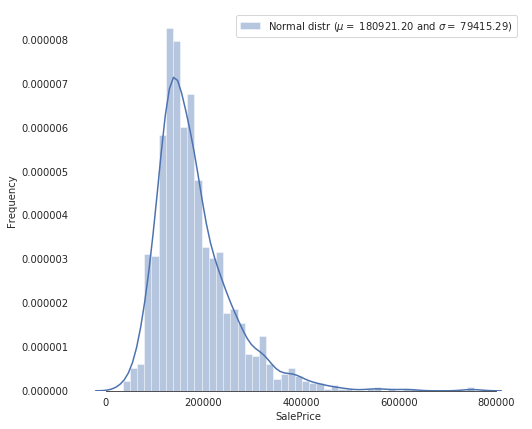

In [3]:
# Get parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
plt.legend(['Normal distr ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
sns.despine(trim=True, left=True)
plt.show()

#### QQ-plot

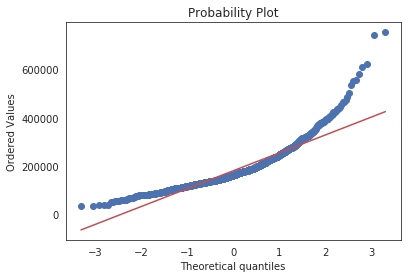

In [4]:
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed. Linear models love normally distributed data, so we need to transform this variable and make it normally distributed. Also we need to drop outliers.

In [5]:
train['SalePrice'] = np.log1p(train['SalePrice'])
train.drop(train[(train['OverallQual'] < 5) & (train['SalePrice'] > 200000)].index, inplace=True)
train.drop(train[(train['GrLivArea'] > 4500) & (train['SalePrice'] < 300000)].index, inplace=True)

### Features engineering

In [6]:
n_train = train.shape[0]
n_test = test.shape[0]
y = train.SalePrice.values
all_data = pd.concat((train, test))
all_data.drop(['SalePrice'], axis=1, inplace=True)

#### Fill missing data

In [7]:
features_type_str = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 
                     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Alley', 'Fence', 'PoolQC', 
                     'FireplaceQu', 'MiscFeature', 'MasVnrType', 'MSSubClass']

features_type_num = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                     'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

all_data.drop(['Utilities'], axis=1, inplace=True)    

all_data[features_type_str] = all_data[features_type_str].fillna('None')
all_data[features_type_num] = all_data[features_type_num].fillna(0)

all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0], inplace=True)
all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0], inplace=True)
all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0], inplace=True)
all_data['SaleType'].fillna(all_data['SaleType'].mode()[0], inplace=True)

all_data['Electrical'].fillna('SBrkr', inplace=True)
all_data['Functional'].fillna('Typ', inplace=True)
all_data['KitchenQual'].fillna('TA', inplace=True)

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(
    lambda x: x.fillna(x.mode()[0]))

#### Check for missing data (dataframe must be empty)

In [8]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head()

,Missing Ratio


#### Transforming some numerical variables that are really categorical

In [9]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#### Apply Label encoder for some columns

In [10]:
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(all_data[c].values.tolist())
    all_data[c] = lbl.transform(all_data[c])

#### Additional features

In [11]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']

all_data['BsmtFinType1_Unf'] = (all_data['BsmtFinType1'] == 'Unf') * 1
all_data['HasWoodDeck'] = (all_data['WoodDeckSF'] == 0) * 1
all_data['HasOpenPorch'] = (all_data['OpenPorchSF'] == 0) * 1
all_data['HasEnclosedPorch'] = (all_data['EnclosedPorch'] == 0) * 1
all_data['Has3SsnPorch'] = (all_data['3SsnPorch'] == 0) * 1
all_data['HasScreenPorch'] = (all_data['ScreenPorch'] == 0) * 1
# all_data['YearsSinceRemodel'] = all_data['YrSold'].astype(int) - all_data['YearRemodAdd'].astype(int)
all_data['Total_Home_Quality'] = all_data['OverallQual'] + all_data['OverallCond']
all_data = all_data.drop(['Street', 'PoolQC'], axis=1)

all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] + 
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) + 
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] + all_data['EnclosedPorch'] + 
                              all_data['ScreenPorch'] + all_data['WoodDeckSF'])

all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_data['2ndFlrSF'] = all_data['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_data['GarageArea'] = all_data['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_data['GarageCars'] = all_data['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_data['LotFrontage'] = all_data['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_data['MasVnrArea'] = all_data['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [12]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01 + res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_data = logs(all_data, log_features)

In [13]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 'TotalBsmtSF_log', '1stFlrSF_log', 
                    '2ndFlrSF_log', 'GrLivArea_log','GarageCars_log', 'GarageArea_log']

all_data = squares(all_data, squared_features)

#### Check the skew of all numerical features

In [14]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

#### Box Cox Transformation of (highly) skewed features

In [15]:
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index
lam = 0.15

for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

#### Dummy Coding

In [16]:
all_data = pd.get_dummies(all_data)

#### Dividing data

In [17]:
train = all_data[:n_train]
test = all_data[n_train:]

## Part 2: Modeling

In [18]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler

#### Validation function

In [53]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_error", cv=kf))
    return(rmse)

In [54]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)


GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5)


model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=7, nthread=-1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

In [55]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1) 

In [56]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Averaged base models score: 0.1085 (0.0079)


In [57]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                self.base_models_[i].append(instance)
                
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [58]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1079 (0.0079)


In [59]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [60]:
stacked_averaged_models.fit(train.values, y)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(mean_absolute_error(y, stacked_train_pred))

0.04966369077543138


In [61]:
model_xgb.fit(train, y)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(mean_absolute_error(y, xgb_train_pred))

0.05534954284019851


In [62]:
model_lgb.fit(train, y)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(mean_absolute_error(y, lgb_train_pred))

0.04884126902414621


In [63]:
ensemble = stacked_pred * 0.70 + xgb_pred * 0.15 + lgb_pred * 0.15

## Part 3: Dataset for Kaggle

In [64]:
sub = pd.DataFrame()
sub['Id'] = test.index.values
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

In [66]:
sub.head(10)

,Id,SalePrice
0,1461,122148.235314
1,1462,159094.413968
2,1463,184760.862494
3,1464,194257.960181
4,1465,192246.342810
5,1466,174083.297317
6,1467,179701.970085
7,1468,163339.707939
8,1469,183134.662560
9,1470,120343.331366
